# 프로토콜 설계
① 3개의 패킷 형식
- 클라이언트 → 서버
  { 'user'      : name,
    'echoOption': option,
    'message'   : message }
---
- 서버 → 클라이언트 정상 패킷
{ "message": capitalizedSentence,
  "status" : 700 }
---
- 서버 → 클라이언트 오류 패킷
{ "message": errorMessage,
  "status" : 701 ~ 704 중 한가지 }
---

② 패킷의 송/수신 순서

- 클라이언트에서 JSON 형식의 패킷 데이터를 만들어서 서버로 전송한다.
- 서버에서 패킷 데이터의 값을 읽어들여 option 값에 따라 적당한 패킷 데이터를 만든다.
- 서버에서 만들어진 패킷 데이터를 클라이언트로 전송한다.
---
③ 각 패킷 송/수신 시 수행되는 동작

1. 클라이언트는 사용자 이름(user)과 에코 옵션(echoOption)을 포함한 JSON 형식의 패킷을 생성하여 서버로 전송한다.
- 이때 메시지(message)는 초기에는 빈 문자열이거나 “None”이다.
- echoOption은 다음 중 하나의 값이다: 
  일반 에코 (그대로 출력), 
  대문자로 변환, 
  소문자로 변환, 
  프로그램 종료 요청
---
2. 서버는 클라이언트로부터 전달받은 패킷을 디코딩하여 echoOption 값을 확인한다.
echoOption이 정수가 아니거나 허용된 범위(1~4)가 아닌 경우, 
서버는 오류 상태 코드와 함께 오류 메시지를 포함한 JSON 패킷을 클라이언트로 전송한다.
•	상태 코드
- 700: 정상
- 701: 1 미만의 정수
- 702: 정수가 아닌 실수
- 703: 4 초과의 정수
- 704: 문자열 등 정수가 아닌 기타 입력
---
3. 서버가 유효한 옵션을 수신했을 경우, 클라이언트는 메시지 입력을 진행한다. 
메시지를 포함한 JSON 패킷이 다시 서버로 전송된다.
서버는 해당 메시지를 echoOption 값에 따라 다음과 같이 가공한다:
- 1: 입력 그대로 반환
- 2: .upper() 함수를 적용해 대문자로 변환
- 3: .lower() 함수를 적용해 소문자로 변환
- 4: “exit” 메시지를 전송하고 서버 종료
---
4. 서버는 가공된 메시지(capitalizedSentence)를 포함한 정상 응답 패킷을 전송한다.
---
5. 클라이언트는 서버 응답을 출력하며, 받은 메시지가 “exit”일 경우 프로그램을 종료한다.
---

# 클라이언트

필요한 패키지 import

In [ ]:
import json
from socket import *

JSON 형식의 데이터 반환하는 함수

In [ ]:
def getJsonData(name="Default", option="1", message="None"):
    sentence = {
        'user'      : name,
        'echoOption': option,
        'message'   : message
    }
    return json.dumps(sentence)

서버 초기 설정

In [ ]:
serverName   = '127.0.0.1'
serverPort   = 12001
clientSocket = socket(AF_INET, SOCK_STREAM)
clientSocket.connect((serverName, serverPort))

메인 프로그램 동작

In [ ]:
name = input('사용자 이름 입력: ')
while True:
    print('에코 옵션 (1. 일반 에코, 2: 대문자로 에코, 3: 소문자로 에코, 4: 채팅 종료)')
    try:
        option_input = input("입력: ")  # 먼저 문자열로 입력받음
        # 정수 변환 시도
        try:
            option = int(option_input)
        except ValueError:
            # 실수 또는 문자열 입력 시 바로 서버로 오류 코드 전송 (702 또는 704)
            json_data = getJsonData(name, option_input)  # option_input을 그대로 보냄
            clientSocket.send(json_data.encode())

            response      = clientSocket.recv(1024).decode()
            json_response = json.loads(response)

            print(f"{json_response['status']}, {json_response['message']}")
            continue  # 오류 발생 시 다시 옵션 입력 요청

        # JSON 인코딩 후 server로 전송 (message 없이 option만 보냄)
        json_data = getJsonData(name, option)
        clientSocket.send(json_data.encode())

        # 서버 응답 받기
        response         = clientSocket.recv(1024).decode()
        json_response    = json.loads(response)
        modifiedSentence = json_response["message"]
        serverStatus     = json_response["status"]

        # 오류 코드 확인 (701~704)
        if 701 <= serverStatus <= 704:
            print(f"{serverStatus}, {modifiedSentence}")
            continue  # 오류 발생 시 다시 옵션 입력 받음

        # 프로그램 종료 (option == 4)
        if option == 4 and modifiedSentence == 'exit':
            print('프로그램을 종료함')
            break

        # 정상 메시지 처리
        message   = input('메시지 입력: ')
        json_data = getJsonData(name, option, message)
        clientSocket.send(json_data.encode())

        # 서버 응답 받기
        response         = clientSocket.recv(1024).decode()
        json_response    = json.loads(response)
        modifiedSentence = json_response["message"]
        
        print(f"[ {name} ]: {modifiedSentence}")

    # KeyboardInterrupt 처리
    except KeyboardInterrupt:
        print("KeyboardInterrupt")
        json_data = getJsonData("KeyboardInterrupt", 4, "KeyboardInterrupt")
        clientSocket.send(json_data.encode())
        clientSocket.close()
        break

clientSocket.close()

# 서버

필요한 패키지 import

In [ ]:
import json
from socket import *

서버 초기 설정

In [ ]:
serverPort   = 12001
serverSocket = socket(AF_INET, SOCK_STREAM)
serverSocket.bind(('', serverPort))
serverSocket.listen(1)
print('The server is ready to receive')
connectionSocket, addr = serverSocket.accept()

상태코드에 따른 오류 문구

In [ ]:
error701 = "ValueError: integer less than 1"      # 0 이하의 정수 입력 오류
error702 = "ValueError: non-integer(real number)" # 정수가 아닌 실수 입력 오류
error703 = "ValueError: integer more than 4"      # 5 이상의 정수 입력 오류
error704 = "ValueError: non-integer(string)"      # 문자 입력 오류

메인 프로그램 작동

In [ ]:
while True:
    try:
        # 클라이언트에서 값 받고 추출하기
        data      = connectionSocket.recv(1024)
        json_data = json.loads(data.decode())
        user      = json_data['user']
        option    = json_data['echoOption']
        message   = json_data['message']
        if message != "None":
            print(f"Before: [ {user} ]: {message}")
        # option이 문자열이면 숫자로 변환 시도
        if isinstance(option, str):
            if option.replace('.', '', 1).isdigit():  # 실수인지 확인
                response = json.dumps({
                    "message": error702,
                    "status" : 702
                })
                connectionSocket.send(response.encode())
                continue
            else:  # 문자열인 경우
                response = json.dumps({
                    "message": error704,
                    "status" : 704
                })
                connectionSocket.send(response.encode())
                continue

        # option이 정수인지 확인 
        # (1: 그대로, 2: 대문자화, 3: 소문자화, 4: 프로그램 종료)
        if isinstance(option, int):
            if 1 <= option <= 4:
                if   option == 2:
                    capitalizedSentence = message.upper()
                elif option == 3:
                    capitalizedSentence = message.lower()
                elif option == 4:
                    print('프로그램 종료')
                    response = json.dumps({
                        "message": "exit",
                        "status" : 700
                    })
                    connectionSocket.send(response.encode())
                    break
                else:
                    capitalizedSentence = message
            # option이 1 이하면 701, 5 이상이면 703 반환
            else:
                error_msg = error701 if option < 1 else error703
                response  = json.dumps({
                    "message": error_msg,
                    "status" : 701 if option < 1 else 703
                })
                connectionSocket.send(response.encode())
                continue
        # 이외의 경우 오류처리
        else:
            response = json.dumps({
                "message": error704,
                "status" : 704
            })
            connectionSocket.send(response.encode())
            continue
        if message != "None":
            print(f"After : [ {user} ]: {capitalizedSentence}")

        response = json.dumps({
            "message": capitalizedSentence,
            "status" : 700
        })
        connectionSocket.send(response.encode())

    except ValueError:
        response = json.dumps({
            "message": error702,
            "status" : 702
        })
        connectionSocket.send(response.encode())

connectionSocket.close()

# 실행 화면 예시
- 클라이언트

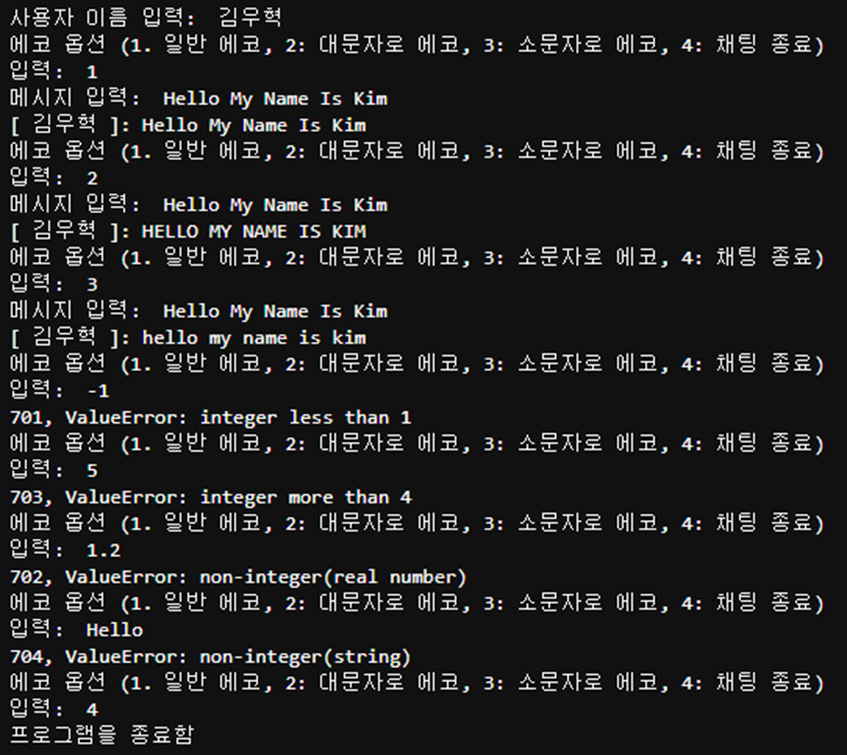

- 서버

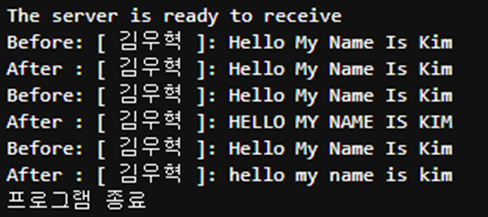